In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# XGBoost
import xgboost as xgb

# Model Selection & Validation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Metrics
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    balanced_accuracy_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve, auc
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully
📅 Analysis Date: 2025-11-13 00:49:29


In [2]:
# Cell 3: Load Data
print("="*80)
print("DATA LOADING")
print("="*80)

df = pd.read_parquet(
    r'C:\Users\Asus\Documents\GitHub\Credit-Scoring\data\data-processing\flat_table\flat_credit_model_20251027_143321.parquet',
    engine="fastparquet"
)

print(f"\n📊 Dataset Shape: {df.shape}")
print(f"\n📈 Class Distribution:")
class_dist = df["TARGET"].value_counts()
print(f"  No Default (0): {class_dist[0]:,} ({class_dist[0]/len(df)*100:.2f}%)")
print(f"  Default (1): {class_dist[1]:,} ({class_dist[1]/len(df)*100:.2f}%)")

# Prepare data
X = df.drop(columns=["TARGET", "SK_ID_CURR"]).fillna(0)
y = df["TARGET"].astype(int)

# Calculate imbalance ratio
imbalance_ratio = class_dist[0] / class_dist[1]
print(f"\n⚖️ Imbalance Ratio: {imbalance_ratio:.2f}:1")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Training Set: {X_train.shape}")
print(f"✅ Test Set: {X_test.shape}")

DATA LOADING

📊 Dataset Shape: (307511, 66)

📈 Class Distribution:
  No Default (0): 282,686 (91.93%)
  Default (1): 24,825 (8.07%)

⚖️ Imbalance Ratio: 11.39:1

✅ Training Set: (246008, 64)
✅ Test Set: (61503, 64)


In [3]:
# Baseline XGBoost Model
print("="*80)
print("BASELINE XGBOOST MODEL")
print("="*80)

# Simple baseline model
baseline_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_jobs=-1
)

print("\n🚀 Training baseline model...")
baseline_model.fit(X_train, y_train)

# Evaluate
y_prob_baseline = baseline_model.predict_proba(X_test)[:, 1]
y_pred_baseline = baseline_model.predict(X_test)

print("\n📊 Baseline Performance:")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_baseline):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_baseline):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_baseline):.4f}")

BASELINE XGBOOST MODEL

🚀 Training baseline model...

📊 Baseline Performance:
  ROC-AUC: 0.7022
  F1-Score: 0.0048
  Precision: 0.5217
  Recall: 0.0024


In [4]:
# Optimized XGBoost with Class Weights
print("="*80)
print("OPTIMIZED XGBOOST MODEL")
print("="*80)

# Calculate scale_pos_weight
scale_pos_weight = imbalance_ratio * 4.0
print(f"\nScale Pos Weight: {scale_pos_weight:.2f}")

optimized_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='auc',
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("\n🚀 Training optimized model...")
optimized_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

print(f"\n✅ Best iteration: {optimized_model.best_iteration}")
print(f"✅ Best AUC: {optimized_model.best_score:.4f}")

# Evaluate
y_prob_optimized = optimized_model.predict_proba(X_test)[:, 1]
y_pred_optimized = optimized_model.predict(X_test)

print("\n📊 Optimized Performance:")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_optimized):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_optimized):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_optimized):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_optimized):.4f}")

OPTIMIZED XGBOOST MODEL

Scale Pos Weight: 45.55

🚀 Training optimized model...
[0]	validation_0-auc:0.63771
[100]	validation_0-auc:0.70138
[200]	validation_0-auc:0.70376
[260]	validation_0-auc:0.70405

✅ Best iteration: 210
✅ Best AUC: 0.7042

📊 Optimized Performance:
  ROC-AUC: 0.7042
  F1-Score: 0.1622
  Precision: 0.0885
  Recall: 0.9710


In [5]:
# Compare Baseline vs Optimized
print("="*80)
print("BASELINE VS OPTIMIZED COMPARISON")
print("="*80)

comparison_data = {
    'Model': ['Baseline', 'Optimized'],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_baseline),
        roc_auc_score(y_test, y_prob_optimized)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_optimized)
    ],
    'Precision': [
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_optimized)
    ],
    'Recall': [
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_optimized)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Calculate improvement
improvement = {
    'ROC-AUC': (comparison_df.loc[1, 'ROC-AUC'] - comparison_df.loc[0, 'ROC-AUC']) / comparison_df.loc[0, 'ROC-AUC'] * 100,
    'F1-Score': (comparison_df.loc[1, 'F1-Score'] - comparison_df.loc[0, 'F1-Score']) / comparison_df.loc[0, 'F1-Score'] * 100,
    'Recall': (comparison_df.loc[1, 'Recall'] - comparison_df.loc[0, 'Recall']) / comparison_df.loc[0, 'Recall'] * 100
}

print("\n📈 Improvement:")
for metric, value in improvement.items():
    print(f"  {metric}: {value:+.2f}%")

BASELINE VS OPTIMIZED COMPARISON

     Model  ROC-AUC  F1-Score  Precision   Recall
 Baseline 0.702177  0.004812   0.521739 0.002417
Optimized 0.704240  0.162222   0.088504 0.970997

📈 Improvement:
  ROC-AUC: +0.29%
  F1-Score: +3271.52%
  Recall: +40075.00%


FEATURE IMPORTANCE ANALYSIS

🔝 Top 20 Most Important Features:
                 feature  importance
            has_job_flag    0.045645
      cc_avg_utilization    0.038091
                dpd_mean    0.035494
      active_loans_count    0.033855
               age_years    0.033775
       total_utilization    0.033374
       raw_days_employed    0.029717
         raw_goods_price    0.027214
      closed_loans_count    0.027022
bur_raw_total_credit_sum    0.024939
        employment_years    0.022840
          raw_cc_records    0.022795
   ins_raw_on_time_count    0.022761
          raw_credit_amt    0.020321
        total_credit_sum    0.019670
           on_time_ratio    0.019405
      cc_max_utilization    0.019030
   ins_raw_total_payment    0.018738
     cc_has_overdue_flag    0.018666
         cc_total_months    0.018329


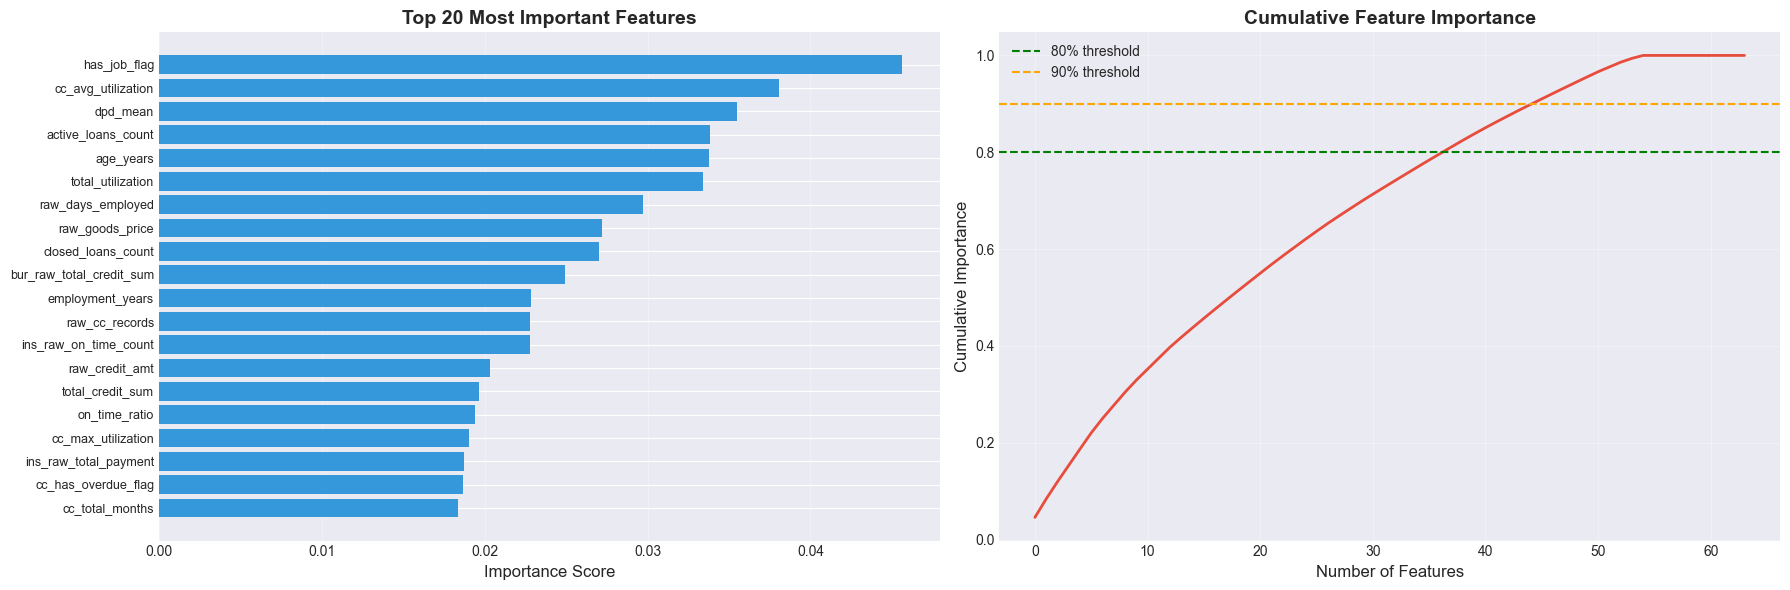


📊 Feature Selection Insights:
  Features for 80% importance: 37 out of 64
  Features for 90% importance: 45 out of 64
  Potential feature reduction: 27 features (42.2%)


In [6]:
# Feature Importance Analysis
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': optimized_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 20 features
ax1 = axes[0]
top_20 = feature_importance.head(20)
ax1.barh(range(len(top_20)), top_20['importance'], color='#3498db')
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature'], fontsize=9)
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Cumulative importance
ax2 = axes[1]
cumsum = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()
ax2.plot(range(len(cumsum)), cumsum, linewidth=2, color='#e74c3c')
ax2.axhline(y=0.8, color='green', linestyle='--', label='80% threshold')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Features', fontsize=12)
ax2.set_ylabel('Cumulative Importance', fontsize=12)
ax2.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate how many features for 80% and 90% importance
features_80 = (cumsum <= 0.8).sum()
features_90 = (cumsum <= 0.9).sum()

print(f"\n📊 Feature Selection Insights:")
print(f"  Features for 80% importance: {features_80} out of {len(X.columns)}")
print(f"  Features for 90% importance: {features_90} out of {len(X.columns)}")
print(f"  Potential feature reduction: {len(X.columns) - features_80} features ({(len(X.columns) - features_80)/len(X.columns)*100:.1f}%)")

THRESHOLD OPTIMIZATION

🎯 Best Threshold for F1-Score:
  Threshold: 0.860
  F1-Score: 0.2600
  Precision: 0.2017
  Recall: 0.3656
  Business Cost: $3,509,200

💰 Best Threshold for Business Cost:
  Threshold: 0.630
  F1-Score: 0.1829
  Precision: 0.1018
  Recall: 0.8979
  Business Cost: $2,472,650


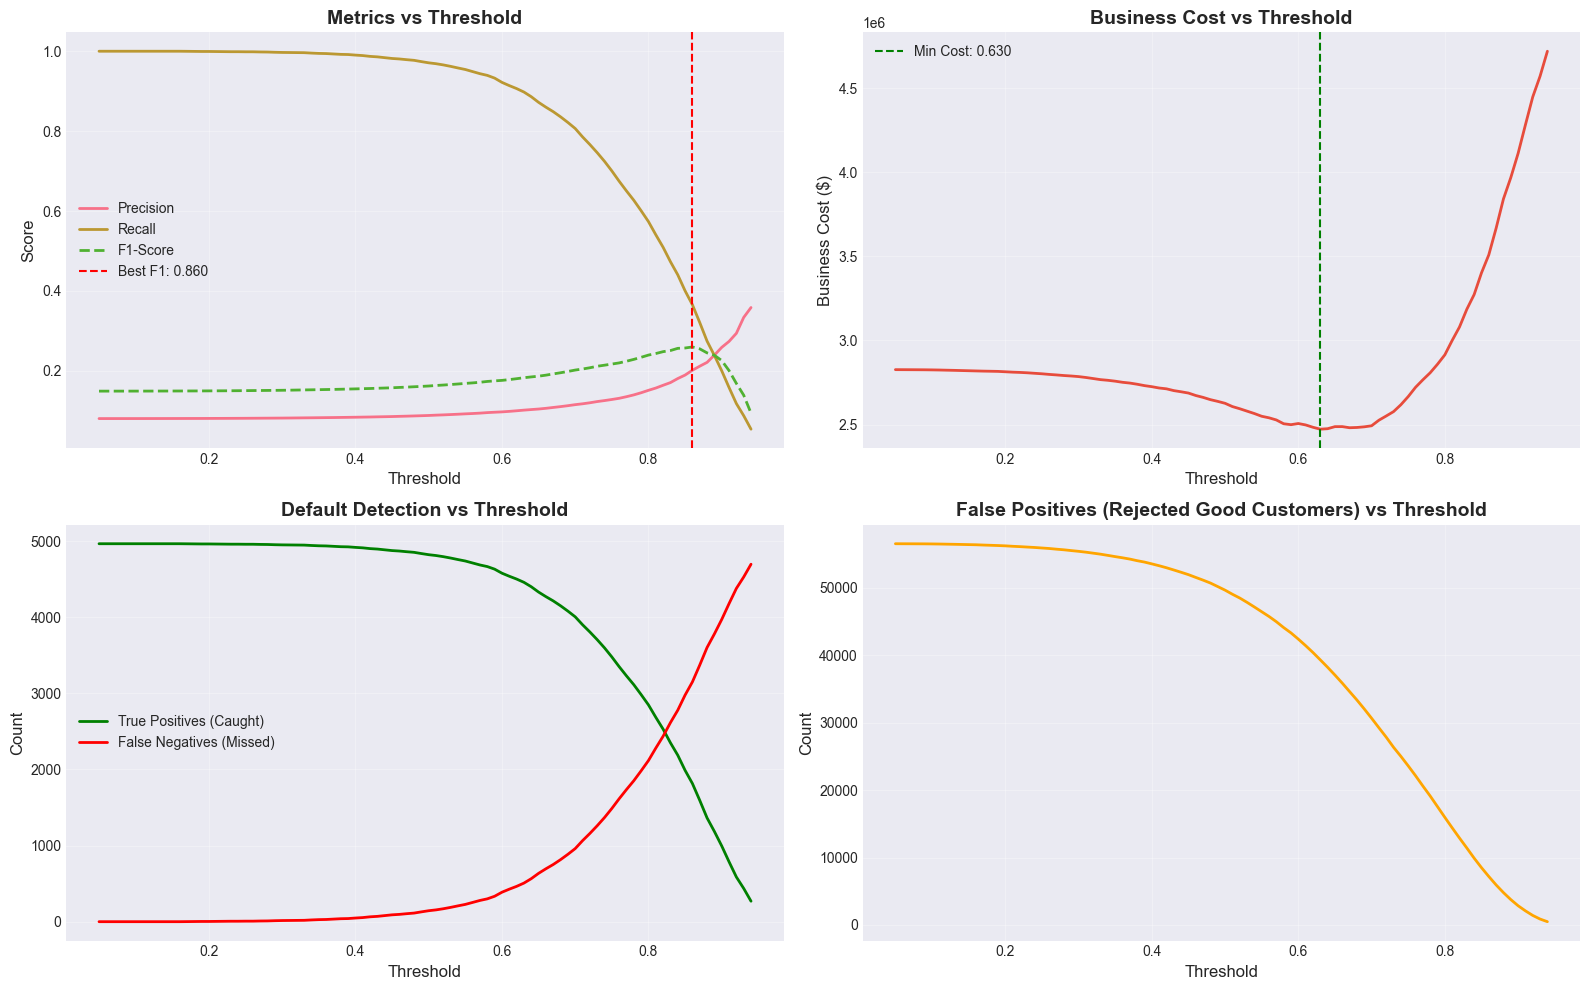

In [7]:
# Threshold Optimization
def find_optimal_threshold(y_true, y_prob, metric='f1'):
    """Find optimal threshold for classification"""
    thresholds = np.arange(0.05, 0.95, 0.01)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        if y_pred.sum() > 0:
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            balanced_acc = balanced_accuracy_score(y_true, y_pred)
            
            # Business cost
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel()
            business_cost = (fn * 1000) + (fp * 50)
            
            results.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'balanced_accuracy': balanced_acc,
                'business_cost': business_cost,
                'tp': tp,
                'fp': fp,
                'tn': tn,
                'fn': fn
            })
    
    results_df = pd.DataFrame(results)
    
    # Find best threshold
    best_f1_idx = results_df['f1'].idxmax()
    best_cost_idx = results_df['business_cost'].idxmin()
    
    return results_df, results_df.loc[best_f1_idx], results_df.loc[best_cost_idx]

print("="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

threshold_results, best_f1, best_cost = find_optimal_threshold(y_test, y_prob_optimized)

print("\n🎯 Best Threshold for F1-Score:")
print(f"  Threshold: {best_f1['threshold']:.3f}")
print(f"  F1-Score: {best_f1['f1']:.4f}")
print(f"  Precision: {best_f1['precision']:.4f}")
print(f"  Recall: {best_f1['recall']:.4f}")
print(f"  Business Cost: ${best_f1['business_cost']:,.0f}")

print("\n💰 Best Threshold for Business Cost:")
print(f"  Threshold: {best_cost['threshold']:.3f}")
print(f"  F1-Score: {best_cost['f1']:.4f}")
print(f"  Precision: {best_cost['precision']:.4f}")
print(f"  Recall: {best_cost['recall']:.4f}")
print(f"  Business Cost: ${best_cost['business_cost']:,.0f}")

# Visualize threshold impact
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# F1, Precision, Recall
ax1 = axes[0, 0]
ax1.plot(threshold_results['threshold'], threshold_results['precision'], label='Precision', linewidth=2)
ax1.plot(threshold_results['threshold'], threshold_results['recall'], label='Recall', linewidth=2)
ax1.plot(threshold_results['threshold'], threshold_results['f1'], label='F1-Score', linewidth=2, linestyle='--')
ax1.axvline(best_f1['threshold'], color='red', linestyle='--', label=f"Best F1: {best_f1['threshold']:.3f}")
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Business Cost
ax2 = axes[0, 1]
ax2.plot(threshold_results['threshold'], threshold_results['business_cost'], linewidth=2, color='#e74c3c')
ax2.axvline(best_cost['threshold'], color='green', linestyle='--', label=f"Min Cost: {best_cost['threshold']:.3f}")
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Business Cost ($)', fontsize=12)
ax2.set_title('Business Cost vs Threshold', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# True Positives & False Negatives
ax3 = axes[1, 0]
ax3.plot(threshold_results['threshold'], threshold_results['tp'], label='True Positives (Caught)', linewidth=2, color='green')
ax3.plot(threshold_results['threshold'], threshold_results['fn'], label='False Negatives (Missed)', linewidth=2, color='red')
ax3.set_xlabel('Threshold', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Default Detection vs Threshold', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# False Positives
ax4 = axes[1, 1]
ax4.plot(threshold_results['threshold'], threshold_results['fp'], linewidth=2, color='orange')
ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('False Positives (Rejected Good Customers) vs Threshold', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

DETAILED PERFORMANCE REPORT (OPTIMAL THRESHOLD)

🎚️ Using Optimal Threshold: 0.860

📋 Classification Report:
                precision    recall  f1-score   support

No Default (0)     0.9400    0.8729    0.9052     56538
   Default (1)     0.2017    0.3656    0.2600      4965

      accuracy                         0.8320     61503
     macro avg     0.5708    0.6192    0.5826     61503
  weighted avg     0.8804    0.8320    0.8531     61503


💼 Confusion Matrix Breakdown:
  True Negatives (Correctly approved): 49,354
  False Positives (Wrongly rejected): 7,184
  False Negatives (Missed defaults): 3,150
  True Positives (Caught defaults): 1,815

📊 Key Metrics:
  Default Detection Rate: 36.56%
  False Alarm Rate: 12.71%
  Specificity: 87.29%
  Precision: 20.17%

💰 Business Impact:
  Cost from missed defaults: $3,150,000
  Cost from rejected good customers: $359,200
  Total Business Cost: $3,509,200


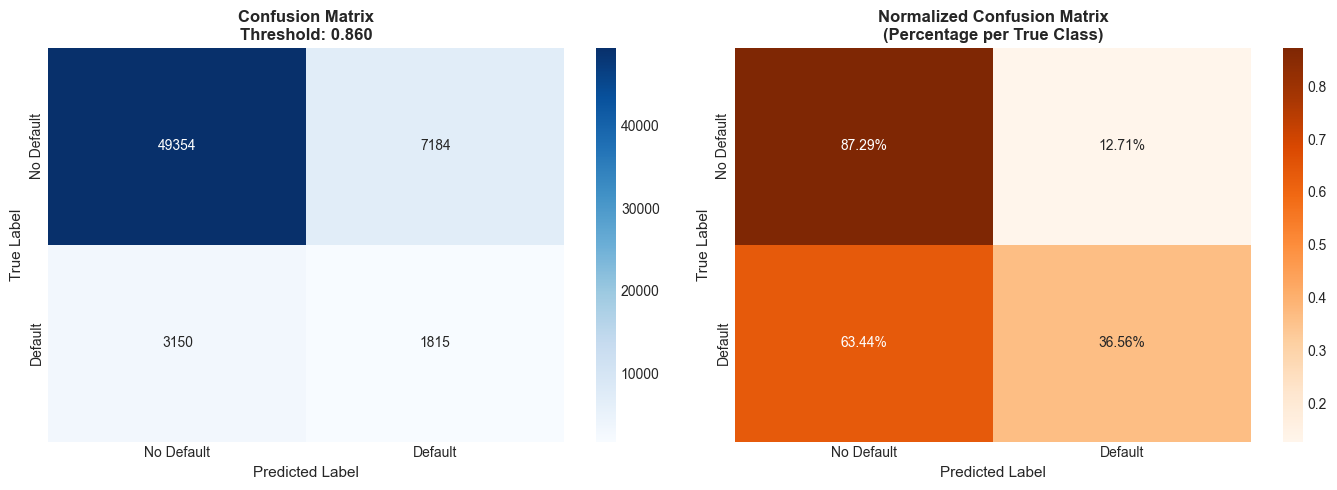

In [8]:
# Detailed Performance Report with Optimal Threshold
print("="*80)
print("DETAILED PERFORMANCE REPORT (OPTIMAL THRESHOLD)")
print("="*80)

# Use best F1 threshold
optimal_threshold = best_f1['threshold']
y_pred_optimal = (y_prob_optimized >= optimal_threshold).astype(int)

print(f"\n🎚️ Using Optimal Threshold: {optimal_threshold:.3f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_optimal, 
                          target_names=['No Default (0)', 'Default (1)'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print("\n💼 Confusion Matrix Breakdown:")
print(f"  True Negatives (Correctly approved): {tn:,}")
print(f"  False Positives (Wrongly rejected): {fp:,}")
print(f"  False Negatives (Missed defaults): {fn:,}")
print(f"  True Positives (Caught defaults): {tp:,}")

print("\n📊 Key Metrics:")
print(f"  Default Detection Rate: {tp/(tp+fn)*100:.2f}%")
print(f"  False Alarm Rate: {fp/(fp+tn)*100:.2f}%")
print(f"  Specificity: {tn/(tn+fp)*100:.2f}%")
print(f"  Precision: {tp/(tp+fp)*100:.2f}%")

# Business Cost
business_cost = (fn * 1000) + (fp * 50)
print(f"\n💰 Business Impact:")
print(f"  Cost from missed defaults: ${fn * 1000:,}")
print(f"  Cost from rejected good customers: ${fp * 50:,}")
print(f"  Total Business Cost: ${business_cost:,}")

# Visualize Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['No Default', 'Default'],
           yticklabels=['No Default', 'Default'])
axes[0].set_title(f'Confusion Matrix\nThreshold: {optimal_threshold:.3f}', 
                 fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges', ax=axes[1],
           xticklabels=['No Default', 'Default'],
           yticklabels=['No Default', 'Default'])
axes[1].set_title('Normalized Confusion Matrix\n(Percentage per True Class)', 
                 fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

ROC AND PRECISION-RECALL CURVES

📊 Curve Metrics:
  ROC-AUC: 0.7042
  PR-AUC: 0.1914


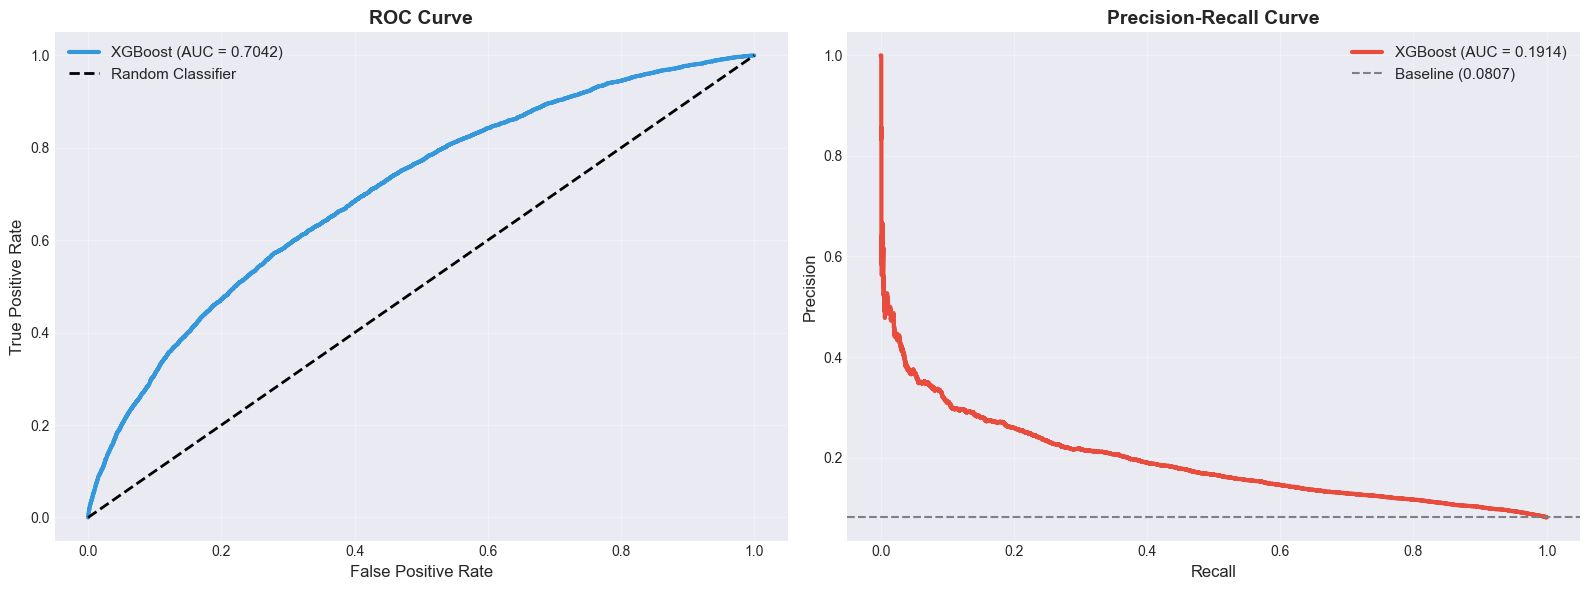

In [9]:
# ROC and PR Curves
print("="*80)
print("ROC AND PRECISION-RECALL CURVES")
print("="*80)

# Calculate curves
fpr, tpr, _ = roc_curve(y_test, y_prob_optimized)
roc_auc = auc(fpr, tpr)

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob_optimized)
pr_auc = auc(recall_curve, precision_curve)

print(f"\n📊 Curve Metrics:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC: {pr_auc:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax1 = axes[0]
ax1.plot(fpr, tpr, linewidth=3, label=f'XGBoost (AUC = {roc_auc:.4f})', color='#3498db')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Precision-Recall Curve
ax2 = axes[1]
ax2.plot(recall_curve, precision_curve, linewidth=3, 
        label=f'XGBoost (AUC = {pr_auc:.4f})', color='#e74c3c')
ax2.axhline(y=y_test.mean(), color='gray', linestyle='--', 
           label=f'Baseline ({y_test.mean():.4f})')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

ERROR ANALYSIS

📊 Prediction Breakdown:
  Correct: 51,169 (83.20%)
  False Positive: 7,184 (11.68%)
  False Negative: 3,150 (5.12%)


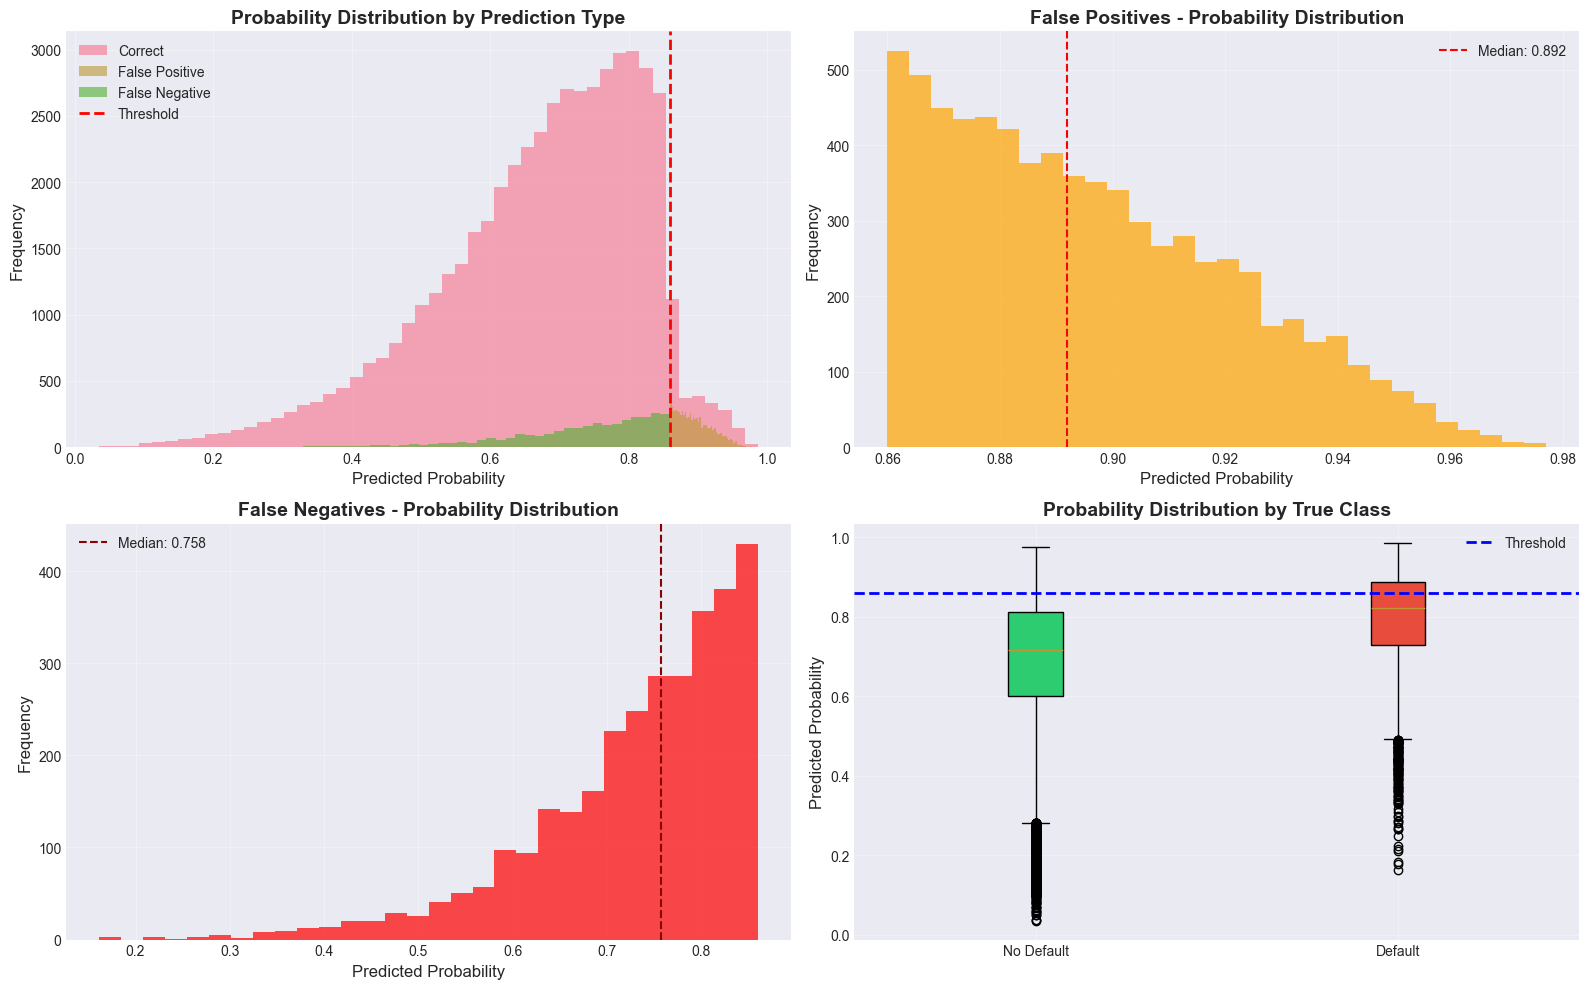


📈 Probability Statistics:

False Positives (Good customers rejected):
  Mean: 0.896
  Median: 0.892
  Min: 0.860, Max: 0.977

False Negatives (Defaults missed):
  Mean: 0.730
  Median: 0.758
  Min: 0.162, Max: 0.860


In [10]:
# Error Analysis
print("="*80)
print("ERROR ANALYSIS")
print("="*80)

# Get predictions with optimal threshold
y_pred_optimal = (y_prob_optimized >= optimal_threshold).astype(int)

# Analyze errors
error_analysis = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': y_pred_optimal,
    'probability': y_prob_optimized
})

# Add error type
error_analysis['error_type'] = 'Correct'
error_analysis.loc[(error_analysis['true_label'] == 0) & (error_analysis['predicted_label'] == 1), 'error_type'] = 'False Positive'
error_analysis.loc[(error_analysis['true_label'] == 1) & (error_analysis['predicted_label'] == 0), 'error_type'] = 'False Negative'

# Count error types
error_counts = error_analysis['error_type'].value_counts()
print("\n📊 Prediction Breakdown:")
for error_type, count in error_counts.items():
    print(f"  {error_type}: {count:,} ({count/len(error_analysis)*100:.2f}%)")

# Analyze probability distribution by error type
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# All predictions
ax1 = axes[0, 0]
for error_type in ['Correct', 'False Positive', 'False Negative']:
    data = error_analysis[error_analysis['error_type'] == error_type]['probability']
    if len(data) > 0:
        ax1.hist(data, bins=50, alpha=0.6, label=error_type)
ax1.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('Predicted Probability', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Probability Distribution by Prediction Type', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# False Positives only
ax2 = axes[0, 1]
fp_probs = error_analysis[error_analysis['error_type'] == 'False Positive']['probability']
if len(fp_probs) > 0:
    ax2.hist(fp_probs, bins=30, color='orange', alpha=0.7)
    ax2.axvline(fp_probs.median(), color='red', linestyle='--', 
               label=f'Median: {fp_probs.median():.3f}')
ax2.set_xlabel('Predicted Probability', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('False Positives - Probability Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# False Negatives only
ax3 = axes[1, 0]
fn_probs = error_analysis[error_analysis['error_type'] == 'False Negative']['probability']
if len(fn_probs) > 0:
    ax3.hist(fn_probs, bins=30, color='red', alpha=0.7)
    ax3.axvline(fn_probs.median(), color='darkred', linestyle='--', 
               label=f'Median: {fn_probs.median():.3f}')
ax3.set_xlabel('Predicted Probability', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('False Negatives - Probability Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Box plot comparison
ax4 = axes[1, 1]
data_to_plot = [
    error_analysis[error_analysis['true_label'] == 0]['probability'],
    error_analysis[error_analysis['true_label'] == 1]['probability']
]
bp = ax4.boxplot(data_to_plot, labels=['No Default', 'Default'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
ax4.axhline(optimal_threshold, color='blue', linestyle='--', linewidth=2, label='Threshold')
ax4.set_ylabel('Predicted Probability', fontsize=12)
ax4.set_title('Probability Distribution by True Class', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Probability Statistics:")
print("\nFalse Positives (Good customers rejected):")
if len(fp_probs) > 0:
    print(f"  Mean: {fp_probs.mean():.3f}")
    print(f"  Median: {fp_probs.median():.3f}")
    print(f"  Min: {fp_probs.min():.3f}, Max: {fp_probs.max():.3f}")

print("\nFalse Negatives (Defaults missed):")
if len(fn_probs) > 0:
    print(f"  Mean: {fn_probs.mean():.3f}")
    print(f"  Median: {fn_probs.median():.3f}")
    print(f"  Min: {fn_probs.min():.3f}, Max: {fn_probs.max():.3f}")

LEARNING CURVES ANALYSIS


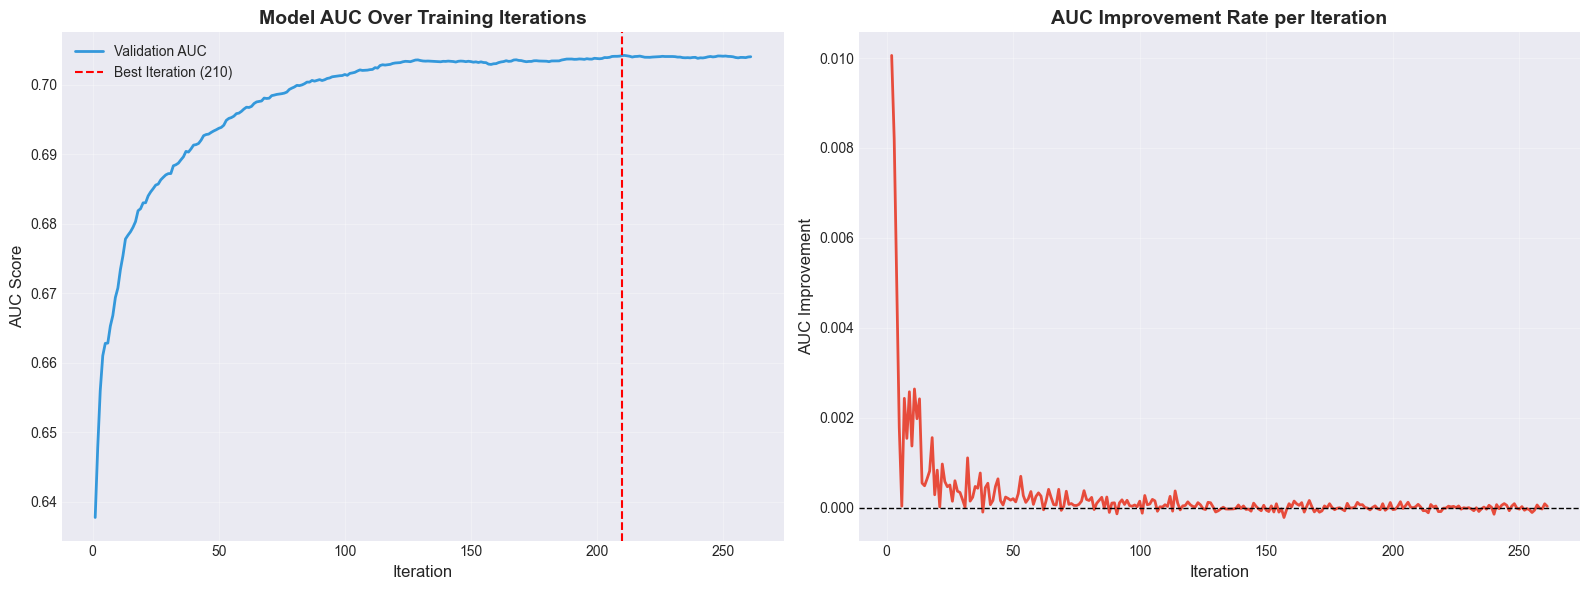


📊 Training Insights:
  Total iterations: 261
  Best iteration: 210
  Early stopped: True
  Final AUC: 0.7041
  Best AUC: 0.7042


In [11]:
# Learning Curves
print("="*80)
print("LEARNING CURVES ANALYSIS")
print("="*80)

# Get training history
evals_result = optimized_model.evals_result()

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# AUC over iterations
ax1 = axes[0]
train_auc = evals_result['validation_0']['auc']
epochs = range(1, len(train_auc) + 1)
ax1.plot(epochs, train_auc, linewidth=2, color='#3498db', label='Validation AUC')
ax1.axvline(optimized_model.best_iteration, color='red', linestyle='--', 
           label=f'Best Iteration ({optimized_model.best_iteration})')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('AUC Score', fontsize=12)
ax1.set_title('Model AUC Over Training Iterations', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Training improvement rate
ax2 = axes[1]
improvement = np.diff(train_auc)
ax2.plot(epochs[1:], improvement, linewidth=2, color='#e74c3c')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('AUC Improvement', fontsize=12)
ax2.set_title('AUC Improvement Rate per Iteration', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Training Insights:")
print(f"  Total iterations: {len(train_auc)}")
print(f"  Best iteration: {optimized_model.best_iteration}")
print(f"  Early stopped: {len(train_auc) < 500}")
print(f"  Final AUC: {train_auc[-1]:.4f}")
print(f"  Best AUC: {max(train_auc):.4f}")

In [12]:
# Save XGBoost Model and Analysis
print("="*80)
print("SAVING XGBOOST MODEL AND ANALYSIS")
print("="*80)

output_dir = r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models"

# Save the optimized model
joblib.dump(optimized_model, f"{output_dir}\\xgboost_final.pkl")

# Save comprehensive metadata
xgb_metadata = {
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_params': optimized_model.get_params(),
    'data_info': {
        'total_samples': len(df),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'n_features': X.shape[1],
        'imbalance_ratio': float(imbalance_ratio)
    },
    'performance': {
        'optimal_threshold': float(optimal_threshold),
        'roc_auc': float(roc_auc),
        'pr_auc': float(pr_auc),
        'f1_score': float(best_f1['f1']),
        'precision': float(best_f1['precision']),
        'recall': float(best_f1['recall']),
        'business_cost': float(best_f1['business_cost'])
    },
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    },
    'best_iteration': int(optimized_model.best_iteration),
    'feature_importance_top20': feature_importance.head(20).to_dict('records')
}

joblib.dump(xgb_metadata, f"{output_dir}\\xgboost_metadata.pkl")

# Save feature importance
feature_importance.to_csv(f"{output_dir}\\xgboost_feature_importance.csv", index=False)

# Save threshold analysis
threshold_results.to_csv(f"{output_dir}\\xgboost_threshold_analysis.csv", index=False)

print("\n✅ XGBoost model saved")
print("✅ Metadata saved")
print("✅ Feature importance saved")
print("✅ Threshold analysis saved")

print("\n🎉 XGBoost Deep Dive Analysis Complete!")

SAVING XGBOOST MODEL AND ANALYSIS

✅ XGBoost model saved
✅ Metadata saved
✅ Feature importance saved
✅ Threshold analysis saved

🎉 XGBoost Deep Dive Analysis Complete!


In [13]:
# Final Summary
print("="*80)
print("XGBOOST MODEL - FINAL SUMMARY")
print("="*80)

print("\n📊 MODEL CONFIGURATION:")
print(f"  N Estimators: {optimized_model.n_estimators}")
print(f"  Learning Rate: {optimized_model.learning_rate}")
print(f"  Max Depth: {optimized_model.max_depth}")
print(f"  Scale Pos Weight: {optimized_model.scale_pos_weight:.2f}")

print("\n🎯 PERFORMANCE METRICS:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC: {pr_auc:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.3f}")
print(f"  F1-Score: {best_f1['f1']:.4f}")
print(f"  Precision: {best_f1['precision']:.4f}")
print(f"  Recall: {best_f1['recall']:.4f}")

print("\n💼 BUSINESS IMPACT:")
print(f"  Defaults Caught: {tp:,} ({tp/(tp+fn)*100:.1f}%)")
print(f"  Defaults Missed: {fn:,} ({fn/(tp+fn)*100:.1f}%)")
print(f"  Good Customers Rejected: {fp:,}")
print(f"  Total Business Cost: ${business_cost:,}")

print("\n🔝 TOP 5 FEATURES:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {idx+1}. {row['feature']}: {row['importance']:.4f}")

print("\n💡 RECOMMENDATIONS:")
print("  ✓ Model is ready for production deployment")
print(f"  ✓ Use threshold: {optimal_threshold:.3f} for optimal F1-Score")
print(f"  ✓ Consider feature reduction to top {features_80} features (80% importance)")
print("  ✓ Monitor false negatives closely (missed defaults)")
print("  ✓ Implement manual review for probabilities near threshold")

print("\n" + "="*80)
print("ANALYSIS COMPLETED")
print("="*80)

XGBOOST MODEL - FINAL SUMMARY

📊 MODEL CONFIGURATION:
  N Estimators: 500
  Learning Rate: 0.05
  Max Depth: 6
  Scale Pos Weight: 45.55

🎯 PERFORMANCE METRICS:
  ROC-AUC: 0.7042
  PR-AUC: 0.1914
  Optimal Threshold: 0.860
  F1-Score: 0.2600
  Precision: 0.2017
  Recall: 0.3656

💼 BUSINESS IMPACT:
  Defaults Caught: 1,815 (36.6%)
  Defaults Missed: 3,150 (63.4%)
  Good Customers Rejected: 7,184
  Total Business Cost: $3,509,200

🔝 TOP 5 FEATURES:
  7. has_job_flag: 0.0456
  30. cc_avg_utilization: 0.0381
  44. dpd_mean: 0.0355
  21. active_loans_count: 0.0339
  1. age_years: 0.0338

💡 RECOMMENDATIONS:
  ✓ Model is ready for production deployment
  ✓ Use threshold: 0.860 for optimal F1-Score
  ✓ Consider feature reduction to top 37 features (80% importance)
  ✓ Monitor false negatives closely (missed defaults)
  ✓ Implement manual review for probabilities near threshold

ANALYSIS COMPLETED
